# The Julia Programming Language: Google Code In'19
### @author: PseudoCodeNerd
## Task : Add the Fashion MNIST model to the Flux model-zoo

**Task Description**

Fashion MNIST is a good way to introduce the concept of autoenoders and for classification tasks. Write an efficient Fashion MNIST implementation using Flux and benchmark it against equivalent implementations in TensorFlow and PyTorch. A good extension might be to have it run smoothly on GPUs too. The FashionMNIST dataset can be easily obtained and unpackaged into ready-to-use Julia data types with the help of MLDatasets.jl. A working example of using Flux for classification of handwritten digits from the MNIST dataset can be found here, for students who are already familiar with basic image detection techniques and want to hit the ground running. Flux's documentation can be found here Another reference material that may interest you is this notebook that handles the FashionMNIST dataset using keras and tensorflow.

If you need GPUs for your task, I'd recommend you to use NextJournal. If you need help setting up a Julia GPU session, just use the interactive chat icon in the bottom of the screen or contact one of the mentors on Slack.

I must explicitly say this that **the code from the model zoo and other sources mentioned sources is solely for reference. Please do copy-paste code without writing proper comments or understanding the code.**



## Introduction
In this notebook I'll be using the Flux Machine Learning Package for Julia to build a simple multilayer perceptron to predict Zalando's articles images. Fashion-MNIST is a dataset of Zalando's article images—consisting of a **training set of 60,000 examples** and a **test set of 10,000 examples**. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Sample here:<br>
![lol](https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true)

Let's start by importing the required packages.

In [1]:
using Flux
using Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv C:\Users\shekh\.julia\packages\CUDAdrv\mCr0O\src\CUDAdrv.jl:69


Flux already has the FashionMNIST built in. [Source](https://github.com/FluxML/Flux.jl/blob/master/src/data/fashion-mnist.jl).

In [2]:
#getting the data from Flux itself
images = Flux.Data.FashionMNIST.images()
labels = Flux.Data.FashionMNIST.labels();

# Example of a image and a label below.
r = rand(1:60000)


34399

The corresponding image and label for this random data-point is.

In [3]:
images[r]

In [4]:
labels[r] #It's a dress.

6

### For reference
Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

### Our aim is to make our neural net predict the labels by looking at a 28x28 image.

## Image Pre-Processing
We'll use <code>hcat</code> (behaves like numpy's reshape function) to stack the images into a single vector and <code>onehotbatch</code> to encode the categorical values into T/F's.

More about <code>onehotbatch</code> :<br>
One hot encoding allowed us to **convert our categorical labels**: "Trouser", "Dress", "Coat", ... etc. **into machine readable values**;<br><br> That is, if our label is "Pullover" in our result set, it would be one-hot encoded against the categories <br><code>["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]<br></code>as <br><code>["false", "false", "true", "false", "false", "false", "false", "false", "false"].</code> <br>In such a matrix, each column represents a one-hot encoded value of the label for the corresponding position in the vector. <br>

In [5]:
X = hcat(float.(reshape.(images, :))...) 
Y = onehotbatch(labels, 0:9) 

10×60000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  1  1  0  1  0  0  0  0  0  1  0  0  …  0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  1  0  0  0  0  1  0  0  0
 0  0  0  0  0  1  0  1  0  0  0  0  0     0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  1  0  0  1  …  0  0  0  0  0  0  0  1  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0

## Creating our ML model (more a Neural Network with 2 layers)
[Read more on Flux Layers](https://fluxml.ai/Flux.jl/stable/models/basics/#Building-Layers-1).
<br>We'll be chaining two dense layers to go from a 28^2 dimensional space (28x28 images) to our predictions which will be 10 dimensional (0-9 types of articles.)

In [32]:
model = Chain(Dense(28^2, 32, relu), Dense(32, 10), softmax)

Chain(Dense(784, 32, relu), Dense(32, 10), softmax)

[softmax](https://towardsdatascience.com/softmax-function-simplified-714068bf8156) : The Softmax regression is a activation function that normalizes an input value into a vector of values that follows a probability distribution whose total sums up to 1. In other words, softmax just converts output to probability distribution.<br>
[Relu](https://stats.stackexchange.com/questions/226923/why-do-we-use-relu-in-neural-networks-and-how-do-we-use-it) are another type of non-linear activation functions used actively in neural networks.It simply sets all negative values computed in the image to 0. The reason we do this, is because we want to introduce a non-linear function into our learning network that mimics very much what our eyes do when detecting images. There are other functions that do similar things such as sigmoid or tanh, which both mimic similar bounded functions, but relu seems to perform faster and gives good results.

See relu link to a Why/How answer on Stack.

### In order to train our model in flux, we will require three functions as parameters:
1. an loss/objective function - allows the network to see how close we are to the result and used for gradient decent
2. an optimizer - a function that operates on the weight parameters of the network, to decrease the loss and drive gradient decent.
3. an evaluation function to show the progress of the training

Awesome documentation on Training from the Flux team [here](https://github.com/FluxML/Flux.jl/blob/master/docs/src/training/training.md)

Now, we write our loss function (we'll be using the log loss function/ better known as Cross-Entropy). The loss function measures the performance of a binary/multiclass classification model (latter, such as ours). <br> 
**Math** behind it [here](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

<br>
ADAM would be our optimizer function (it can be called a advanced, more powerful gradient descent but for neural networks). It is an adaptive learning rate method, which means, it computes individual learning rates for different parameters. [ADAM](https://arxiv.org/pdf/1412.6980.pdf)

In [35]:
#1
loss(x, y) = crossentropy(model(x), y) 
#2
optim = ADAM(); 
#3
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y)) # a way to find average of correct guesses in julia
dataset = repeated((X,Y),200) # repeating the data set 200 times, as opposed to 200 epochs 
evalcb = () -> @show(loss(X, Y)) # callback to show loss

#19 (generic function with 1 method)

### Buckle up, because it's the time to train our (smol) model !

In [35]:
Flux.train!(loss, params(model), dataset, optim, cb = throttle(evalcb, 10));

loss(X, Y) = 2.3620791f0
loss(X, Y) = 1.9865174f0
loss(X, Y) = 1.7601027f0
loss(X, Y) = 1.5901419f0
loss(X, Y) = 1.4566942f0
loss(X, Y) = 1.3407104f0
loss(X, Y) = 1.2393758f0
loss(X, Y) = 1.1476959f0
loss(X, Y) = 1.0679457f0
loss(X, Y) = 1.0048387f0
loss(X, Y) = 0.95166904f0
loss(X, Y) = 0.9043182f0
loss(X, Y) = 0.864224f0
loss(X, Y) = 0.8310807f0
loss(X, Y) = 0.8026322f0
loss(X, Y) = 0.77731687f0
loss(X, Y) = 0.75505835f0
loss(X, Y) = 0.735533f0
loss(X, Y) = 0.718016f0
loss(X, Y) = 0.70237654f0
loss(X, Y) = 0.6885812f0
loss(X, Y) = 0.67597306f0
loss(X, Y) = 0.66427284f0
loss(X, Y) = 0.6535298f0
loss(X, Y) = 0.64366955f0
loss(X, Y) = 0.63447034f0
loss(X, Y) = 0.62585896f0
loss(X, Y) = 0.6178082f0
loss(X, Y) = 0.61024f0
loss(X, Y) = 0.6030882f0
loss(X, Y) = 0.59633154f0
loss(X, Y) = 0.5899332f0
loss(X, Y) = 0.5838449f0
loss(X, Y) = 0.5780466f0
loss(X, Y) = 0.57251835f0
loss(X, Y) = 0.5672301f0
loss(X, Y) = 0.5621674f0
loss(X, Y) = 0.5573126f0
loss(X, Y) = 0.5526478f0
loss(X, Y) = 0.5481

This took around 13 minutes to run on my potato PC. To make it faster we can do smarter things like batching which I have to still learn how to implement.

## Testing our model.
The data-set also had a 'test' set included on which we'll now be running our trained model !

Let's see how that goes...

In [41]:
r = rand(1:12000) # a random data-point in the 12000 large test set.

4597

In [42]:
Flux.Data.FashionMNIST.images(:test)[r] #visualising

Same image - preprocessing as used before but on the test set this time.

In [43]:
X_test = hcat(float.(reshape.(Flux.Data.FashionMNIST.images(:test), :))...)
Y_test = onehotbatch(Flux.Data.FashionMNIST.labels(:test), 0:9);

Running our model on the X_test.

A 10-element array is returned with values between 0 to 1 (probabilities of catetgories being predicted).
This means that the model means to say that the image inputted is 99.94% a trouser (0.9994) and 0.013% dress (0.00013).

In [44]:
model(X_test[:,r])

10-element Array{Float32,1}:
 4.850774e-5  
 0.99945766   
 0.00018068193
 0.00013932848
 0.00017063053
 1.0155961e-7 
 2.5855168e-6 
 3.8150286e-8 
 5.9667695e-7 
 2.269384e-8  

In [46]:
# We can use onecold to compare the true and predicted classes:
onecold(model(X_test[:,r])) - 1 # the minus one is to account for julia's one-indexing. We start
                                    #from 0 but Julia's indexing start at 1.

1

### 1 corresponds to Trouser and as we can see from the image above, it predicts correctly!
## Results
Using <code>accuracy</code>

In [65]:
print("Train Accuracy : ", accuracy(X,Y)*100, " %")

Train Accuracy : 84.38166666666666 %

In [61]:
print("Test Accuracy : ", accuracy(X_test,Y_test)*100," %")

Test Accuracy : 82.87 %

Based on the benchmarks provided by Zalando Research, our simple neural network ranks among the top 20% of the top accuracy !

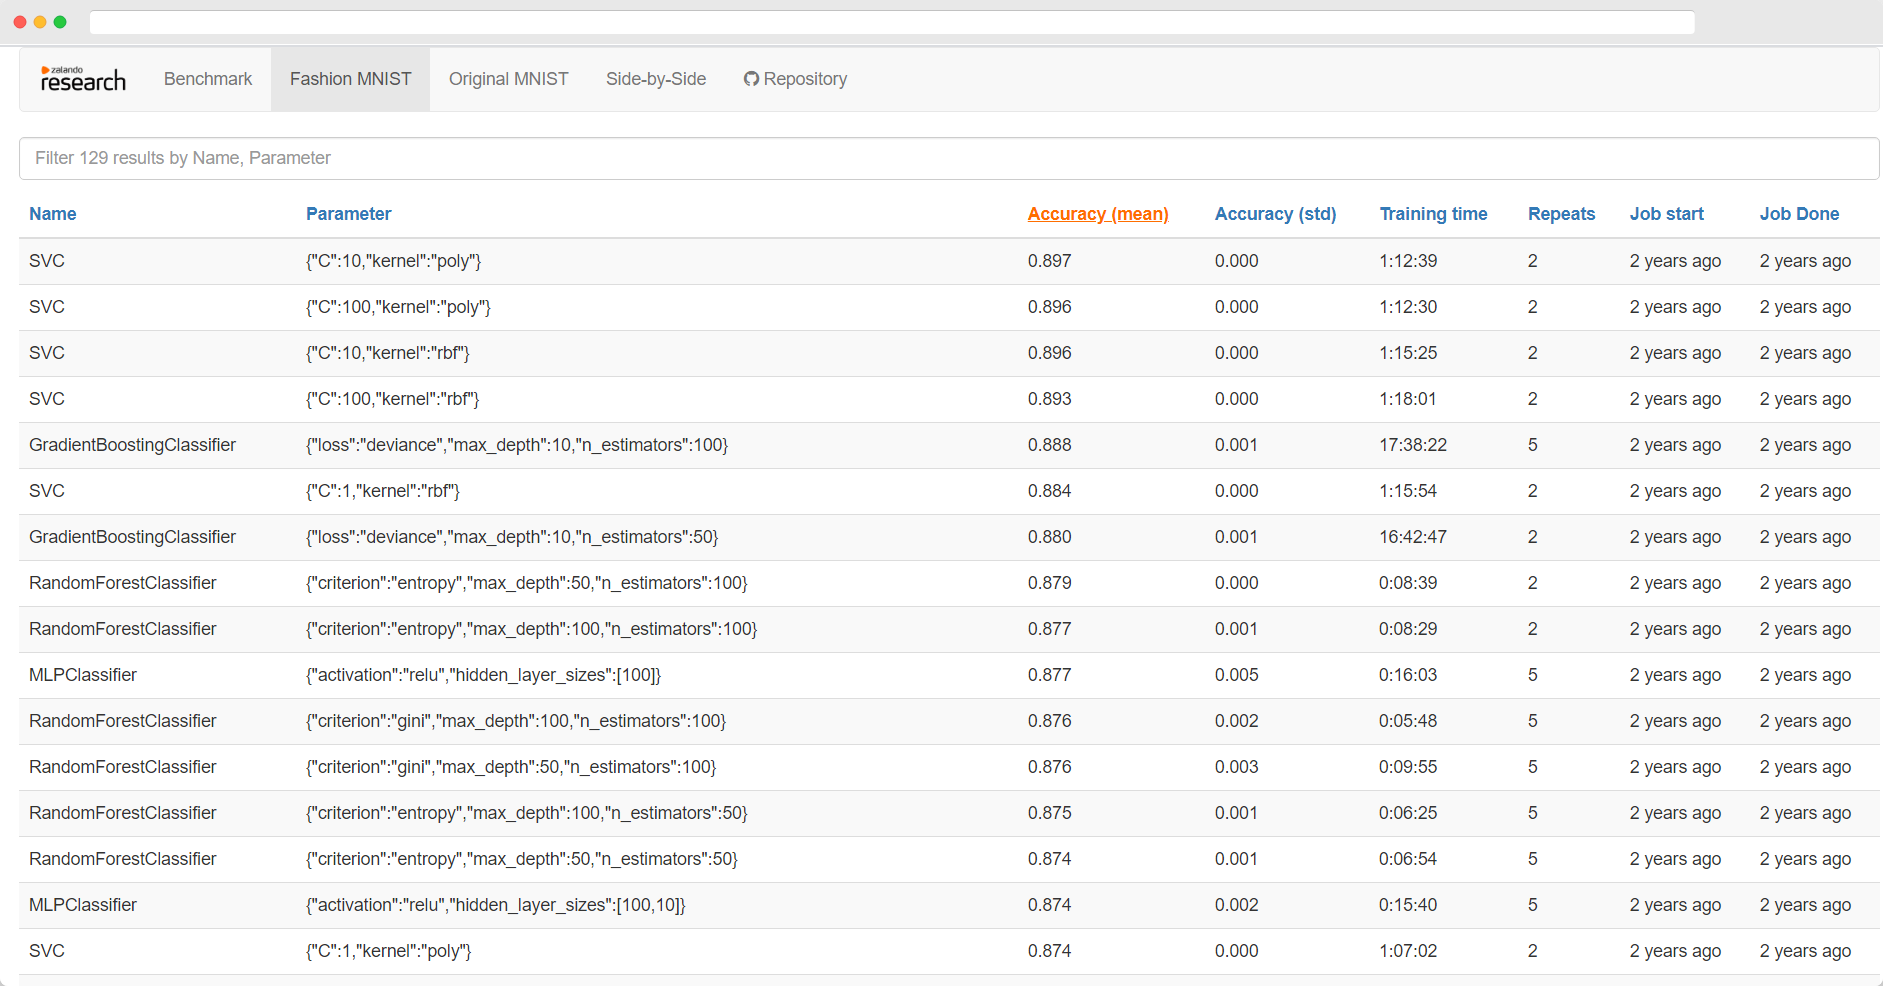

-PseudoCodeNerd

P.S: 85.65% on the test set was achieved via the resnet34 pre-trained CNN by fastAI.
Notebook attached. 

# Update
## Adding a ConvNet
I say (heavily) influenced from https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl.

In [28]:
using Flux, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Printf, BSON

In [23]:
images = Flux.Data.FashionMNIST.images();
labels = Flux.Data.FashionMNIST.labels();

In [24]:
#Bundle images together with labels and group into minibatches.
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X[1])..., 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, :, i] = Float32.(X[idxs[i]])
    end
    Y_batch = onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end
batch_size = 128
mb_idxs = partition(1:length(images), batch_size)
train_set = [make_minibatch(images, labels, i) for i in mb_idxs]


469-element Array{Tuple{Array{Float32,4},Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}},1}:
 ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 1 0 … 0 0])                                           
 ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0

In [25]:
test_imgs = Flux.Data.FashionMNIST.images(:test)
test_labels = Flux.Data.FashionMNIST.labels(:test)
test_set = make_minibatch(test_imgs, test_labels, 1:length(test_imgs))

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 1 0; … ; 0 0 … 0 0; 1 0 … 0 0])

Now that we examined and prepared the data, we can now build our CNN to train the articles images on their corresponding labels. 

There are 3 convulational layers, 3 maxPool layers, a dense layer and finally softmax to give a output in range of 0-->1

**Convulated** : The convolutional layer it convolves the article image with a cumulative result that learns the filter. Convolution is best explained as a a matrix traveling along another matrix and doing an element-wise multiplication against it to get a resulting convolved feature matrix. For further reading, check out [this article](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) that explains the convolution step very well with an animation of the convolution occuring between matrices. The Conv function below, takes the feature matrix dimensions as its first parameter. In other words, the first layer will use a 3x3 matrix and slide it over the image pixels to learn the feature detection filter. The first layer will produce 16 outputs from 1 input as indicated by 1=>16 in the second parameter. The relu function, in the third parameter, is a function that simply sets all negative values computed in the image to 0. 

**Maxpool** : After we apply the convolution layer, we apply another function called max pooling which helps reduce the dimensionality of the features that the network is learning, but still maintains the important feature information for learning. The pooling function in our neural network, slides a 2x2 matrix over different sections of the 2d input and pools them into a single value. So a 28 x 28 matrix pooled by a 2x2 pooling matrix would be reduced to a 14x14 matrix. The pooling function can be anything from max value, average, or sum. Max value is most commonly used, since it seems to be very effective.

**Role of Abpve Layers** :The first 6 layers (3C, 3 MP) are used for feature extraction in the image. hese layers take a 28x28 image input and aggregate into a simpler set of features representing the images. As more images are passed over these 4 layers, the feature extractor portion learns a simplified set of features from the images fed through it. This will make it much easier for the neural net to classify digits in the remaining part of the network

**Dense** :The reshape function's job is to get the pooled data into a form that the Dense neural net can process. The dense neural net takes 288 inputs from the last maxpool function and trains on the data to produce 10 outputs. The outputs are then subjected to the softmax function which essentially squashes the values to values between 0 and 1. All values produced by the softmax function will total 1. 

The error between the output and actual label value will be fed back through the network to train the weights inside the network. This is called backpropogation. The deep learning uses a technique called gradient descent to adjust the weights of the network based on the error. As the network weights are adjusted with each new training dataset (image, label), the neural net model gets better and better at predicting the digit fed through it.

In [26]:
model = Chain(
    
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),

    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),

    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),

    # Reshape 3d tensor into a 2d one, at this point it should be (3, 3, 32, N)
    # which is where we get the 288 in the `Dense` layer below:
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 10),

    softmax,
)


Chain(Conv((3, 3), 1=>16, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 16=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), #7, Dense(288, 10), softmax)

In [27]:
# precompiling model before starting our training loop
model(train_set[1][1])

# `loss()` calculates the crossentropy loss between our prediction `y_hat`
# (calculated from `model(x)`) and the ground truth `y`.  We augment the data
# a bit, adding gaussian random noise to our image to make it more robust.
function loss(x, y)
    # We augment `x` a little bit here, adding in random noise
    x_aug = x .+ 0.1f0*gpu(randn(eltype(x), size(x)))

    y_hat = model(x_aug)
    return crossentropy(y_hat, y)
end

accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

opt = ADAM(0.001)

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [ ]:

best_acc = 0.0
last_improvement = 0
for curr_epoch in 1:100
    global best_acc, last_improvement
    # Train for a single epoch
    Flux.train!(loss, params(model), train_set, opt)

    # Calculate accuracy.
    acc = accuracy(test_set...)
    @info(@sprintf("[%d]: Test accuracy: %.4f", curr_epoch, acc))

    # If this is the best accuracy we've seen so far, save the model out
    if acc >= best_acc
        @info(" New best accuracy! Saving model out to mnist_conv.bson")
        best_acc = acc
        last_improvement = curr_epoch
    end

    # If we haven't seen improvement in 5 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 5 && opt.eta > 1e-6
        opt.eta /= 10.0
        @warn(" Haven't improved in a while, dropping learning rate to $(opt.eta)!")
        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement >= 10
        @warn(" converged.")
        break
    end
end

┌ Info: [1]: Test accuracy: 0.8214
└ @ Main In[29]:10
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[29]:20
┌ Info: [2]: Test accuracy: 0.8493
└ @ Main In[29]:10
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[29]:20
┌ Info: [3]: Test accuracy: 0.8625
└ @ Main In[29]:10
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[29]:20
┌ Info: [4]: Test accuracy: 0.8650
└ @ Main In[29]:10
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[29]:20
┌ Info: [5]: Test accuracy: 0.8727
└ @ Main In[29]:10
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[29]:20
┌ Info: [6]: Test accuracy: 0.8720
└ @ Main In[29]:10
┌ Info: [7]: Test accuracy: 0.8780
└ @ Main In[29]:10
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[29]:20
┌ Info: [8]: Test accuracy: 0.8775
└ @ Main In[29]:10
┌ Info: [9]: Test accuracy: 0.8760
└ @ Main In[29]:1

## (Max) Accuracy achieved : 90.22.
## Training time : 1:06:34

![screely-1577203486322.png](https://i.ibb.co/pnbvkm3/screely-1577203486322.png)